# 🍿 Final Project - The Movie Database

## Introduction 

Is money strong enough to determine profitability, popularity and public appreciation of movies?  
Are movies so plain that one may guess their genres with only their overview? 

For this project, we have targeted movies to analyze them and predict:
- A budget a movie must be allocated, to achieve a certain amount of revenue, public appreciation and popularity (Numerical);
- And the single or multiple genres of a movie, by providing its text overview (Textual).

This project uses the TMDB API but is not endorsed or certified by TMDB.

TODOs:
- TODO: more models 
- TODO: comparison of the models with visualization 
- TODO: conclusion - business recommendations 

Imports we will be using for the project

In [1]:
import requests
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import torch
import spacy
import spacy.cli

from transformers import AutoTokenizer, AutoModel

In [2]:
# For BERT embeddings
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [3]:
# Download the language model, that includes tokenization, part-of-speech tagging, and lemmatization
SPACY_MODEL="fr_core_news_md"
spacy.cli.download(SPACY_MODEL)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 MB 32.5 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


## How did we collect the data?
> The Movie Database (TMDB) is a public API which provides lot of data about movies, series and TV shows, including descriptions, title, ratings, and more.

In [ ]:
DATA_LANGUAGE="fr-FR"
API_KEY = input("Enter your API key: ")

For safety, we will verify whether the entered API_KEY is correct.  

In [ ]:
# Throw error if API_KEY is incorrect
try:
    if not API_KEY:
        raise ValueError("no API_KEY provided")
    url = "https://api.themoviedb.org/3/authentication"
    headers = {"accept": "application/json", "Authorization": f"Bearer {API_KEY}"}
    response = requests.get(url, headers=headers)
    response.raise_for_status()
except Exception as e:
    raise ValueError(
        "API_KEY is not set or invalid. Please provide a valid API key."
    ) from e

We need to get the IDs of the movies we'd like to collect.  

TMDB uses a system of pages, where each page contains a list of movies.  
We will fetch the data with API requests in French. 

In [ ]:
def get_full_array(page):
    try:
        url = f"https://api.themoviedb.org/3/discover/movie?language={DATA_LANGUAGE}&page={page}"
        headers = {
            "accept": "application/json",
            "Authorization": f"Bearer {API_KEY}"
        }

        response = requests.get(url, headers=headers).text
        data = json.loads(response)
        return [movie['id'] for movie in data['results']]
    except Exception as e:
        return []

IDs = []
for page in tqdm(range(1, 501)):
    IDs += get_full_array(page)



In [ ]:
# Display the first 10 movie IDs
IDs[:10] 

After we have collected the movies's ID, we can now get the details of each one in French. 

In [ ]:
data = []
for id in tqdm(range(len(IDs))):
    id = IDs[id]
    url = f"https://api.themoviedb.org/3/movie/{id}?language={DATA_LANGUAGE}"
    headers = {
        "accept": "application/json",
        "Authorization": f"Bearer {API_KEY}"
    }
    response = requests.get(url, headers=headers).text
    movie = json.loads(response)
    data.append(movie)

We convert the array into `Pandas` dataframe

In [ ]:
df = pd.DataFrame(data)
pd.set_option('display.max_columns', None) # To display all columns
df

Finally, we filter the irrelevant rows out,  
and we save the dataframe to a permanent file, to avoid refetching again.  

In [ ]:
df_copy = df.drop(df[df.overview == ""].index)  # Drop rows with empty values in 'overview' (meaning they have no French overview)
df_copy.to_pickle("all_data_fr.pkl") # Save DataFrame to a pickle file (To directly use the DataFrame later, instead of re-fetching)

## Preprocessing data

### Importing and filtering data 

In case we already have fetched the data, we can load the dataframe using the following command.

In [ ]:
df: pd.DataFrame = pd.read_pickle("all_data_fr.pkl")
fr_data = df.copy()
fr_data

### Numerical values

Let's show the plots related to the collected data

In [ ]:
fig, ax = plt.subplots(2,2)

ax[0][0].scatter(fr_data['vote_average'], fr_data['budget'])
ax[0][0].set_xlabel('Vote Average')
ax[0][0].set_ylabel('Budget')

ax[0][1].scatter(fr_data['popularity'], fr_data['budget'])
ax[0][1].set_xlabel('Popularity')
ax[0][1].set_ylabel('Budget')

ax[1][0].scatter(fr_data['revenue'], fr_data['budget'])
ax[1][0].set_xlabel('Revenue')
ax[1][0].set_ylabel('Budget')

ax[1][1].axis('off')

plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.show()

For the numerical values, we remove null values. Then, we split the dataset into train & test datasets.

Finally, we normalize the X train dataset, and we use the obtained values of the normalization for the X test dataset.  
We do not need to normalize the y datasets, because they are predicted. 

We also do not filter out the extreme values (outliers), because they are relevant in our study.

In [11]:
filtered_num_df = fr_data[(fr_data['revenue'] > 0) & (fr_data['budget'] > 0)] # Some movies do not have revenue or budget data
print("filtered df shape: ", filtered_num_df.shape)
numerical_num_df = filtered_num_df[["budget", "vote_average", "revenue", "popularity"]] # Extracting numerical columns

X_num = numerical_num_df[["revenue", "vote_average", "popularity"]]
y_num = numerical_num_df[["budget"]]

X_train_num, X_test_num, y_train_num, y_test_num = train_test_split(
    X_num,
    y_num,
    test_size=0.2,
    random_state=42,
)

num_scaler = StandardScaler()
X_train_num_scaled = num_scaler.fit_transform(X_train_num)
X_test_num_scaled = num_scaler.transform(X_test_num)

X_train_num_scaled

filtered df shape:  (4719, 26)


array([[-0.5687697 ,  0.08987521, -0.18655216],
       [-0.47235884,  1.104772  , -0.22615338],
       [ 1.70138288, -0.02671867,  0.18542752],
       ...,
       [-0.62979439, -1.07208886, -0.25935309],
       [-0.56591946, -0.41624825, -0.24278009],
       [ 1.00672308, -0.24400728,  0.09408265]])

We then display the correlation matrix of the numerical dataset.  
There is low correlation for all features, maybe except between revenue and budget.

Furthermore, we do not need to do PCA, since there are only three features. 

<Axes: >

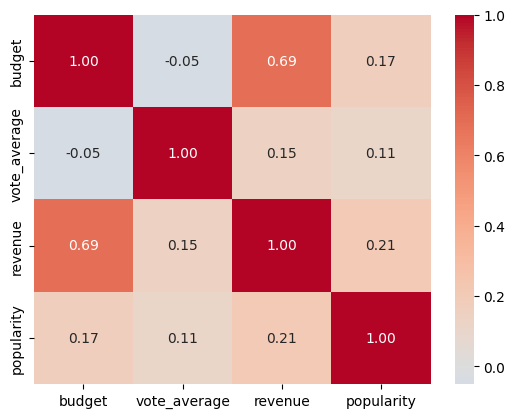

In [15]:
sns.heatmap(numerical_num_df.corr(), annot=True, fmt=".2f", cmap='coolwarm', center=0)

### Textual values

For the textual part, we have analyzed it as a multi-labelling problem, which means that a movie's overview can belong to several `genres`.  
This is a multi-label problem, because a movie can be associated with multiple genres. 

Furthermore, we will preprocess the text: convert the text to lowercase, remove punctuation and lemmatize the words.  
We can preprocess before the train & test split, because there is no risk of data leakage.  

In [ ]:
df_text = fr_data[['overview', 'genres']]

# Convert genres from a list of dictionaries to a list of strings
df_text.loc[:, 'genres'] = df_text['genres'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

# Preprocess the overview text
nlp = spacy.load(SPACY_MODEL)
with nlp.select_pipes(disable=[]):  # We use the parser component (syntaxic analysis), tokenization (text -> list), lemmatization (word to most basic form) and NER (unlinkable words) 
    preprocessed_texts = []
    for (i, doc) in enumerate(nlp.pipe(df_text["overview"], batch_size=50, n_process=-1)):
        # Exclude tokens that are part of a named entity (NER), punctuation, and stop words
        preprocessed_texts.append(' '.join([token.lemma_ for token in doc if not token.ent_type_ and not token.is_punct and not token.is_stop]))
    df_text.loc[:, "overview"] = preprocessed_texts
    
df_text

For the classification, the model needs all the target possibilities. Therefore, we will list all the movie genres into one place. 

Classes are the possible categories of the dataset.  
Labels are the actual categories assigned to the data samples. 

In [ ]:
all_genres_set = set()
for genres in df_text['genres']:
    all_genres_set.update(genres)
all_genres: list[str] = sorted(list(all_genres_set))
all_genres

We will train the models with multi-label binarizer, as the teacher recommended. 

It transforms the labels into numbers. 

In [ ]:
mlb = MultiLabelBinarizer(classes=all_genres)
y_text = mlb.fit_transform(df_text['genres']) # We embed the target

X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(
    df_text['overview'],
    y_text,
    test_size=0.2,
    random_state=42
)

y_text


When we display the class distribution of the dataset, we can observe it is skewed towards "drama".  
We will need to handle this problem later.  

In [ ]:
plt.figure(figsize=(10, 5))
plt.bar(all_genres, height=np.sum(y_text, axis=0))
plt.xticks(rotation=90)
plt.title("Distribution of genre labels")
plt.xlabel("Genres")
plt.ylabel("Number of Samples")
plt.show()

Let's display a word cloud for every movie genre.

We may notice that some words have high correlation with their genre:
- "documentaire" word is highly present in "documentaire" genre;
- "soldat" and "guerre" words are overwhelmingly present in data samples with "guerre" genre;
- "musique" with "musique".

Later on, this would definitely help the label prediction. 

In [ ]:
from wordcloud import WordCloud

def display_wordclouds(n_cols=4):
    n_rows = (len(all_genres) + n_cols - 1) // n_cols
    idx = 0

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for label in all_genres:
        # Get all overviews for this label
        text = " ".join(
            df_text[df_text["genres"].apply(lambda genres: label in genres)]["overview"]
        )
        wordcloud = WordCloud(background_color="white").generate(text)
        axes[idx].imshow(wordcloud, interpolation="bilinear")
        axes[idx].set_title(label)
        axes[idx].axis("off")
        idx += 1

    # Hide any unused subplots
    for j in range(idx, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()
    
display_wordclouds()

In [ ]:
# Calculate the length of each overview in words
plt.figure(figsize=(8, 5))
plt.hist(df_text['overview'].apply(lambda x: len(x.split())), bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Number of Words')
plt.ylabel('Number of Samples')
plt.title('Histogram of Text Sample Lengths')
plt.tight_layout()
plt.show()

## Implementation of models

### Numerical values 

For the numerical values, we are going to use multiple models: Linear Regression, Decision Tree Regressor, Gradient Boosting Regressor and Random Forest Regressor. 

In [ ]:
models = ["Linear Regression", "Decision Tree Regressor", "Gradient Boosting Regressor", "Random Forest Regressor"]
values = []

#### Linear Regression

A simple model that fits a straight line (or hyperplane) to predict a continuous target variable as a linear combination of input features.  
It assumes a linear relationship between features and the target.

In [ ]:
lr_model_num = LinearRegression()
lr_model_num.fit(X_train_num_scaled, y_train_num)

y_pred_num = lr_model_num.predict(X_test_num_scaled)

r2 = r2_score(y_test_num, y_pred_num)
values.append(r2)
print("Mean Squared Error:", mean_squared_error(y_test_num, y_pred_num))
print("R² Score:", r2)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(max_depth=5, random_state=42)
regressor.fit(X_train_num_scaled, y_train_num)
y_pred_num_tree = regressor.predict(X_test_num_scaled)

r2 = r2_score(y_test_num, y_pred_num_tree)
values.append(r2)
print("Mean Squared Error of the Decision Tree Regressor:", mean_squared_error(y_test_num, y_pred_num_tree))
print("R² Score:", r2)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

model = GradientBoostingRegressor(random_state=42)

param_grid = {
    'max_depth': [3, 5, 10, 20, 30, None],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5, 1.0]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1,
    verbose=1,
)

grid_search.fit(X_train_num_scaled, y_train_num)

y_pred = grid_search.predict(X_test_num_scaled)

grid_search

In [ ]:
values.append(grid_search.best_score_)
print("Best R2: ", grid_search.best_score_)
print("Best parameters: ", grid_search.best_params_)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf_model_num  = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4] 
}

scoring = 'r2'

grid_search = GridSearchCV(
    estimator=rf_model_num ,
    param_grid=param_grid,
    scoring=scoring,
    cv=5,
    n_jobs=-1,
    verbose=1,
)

grid_search.fit(X_train_num_scaled, y_train_num)

print("Best parameters:", grid_search.best_params_)

# grid_search

y_pred_rf_num = grid_search.predict(X_test_num_scaled)

r2 = r2_score(y_test_num, y_pred_rf_num)
values.append(r2)
print("Random Forest Mean Squared Error:", mean_squared_error(y_test_num, y_pred_rf_num))
print("Random Forest R² Score:", r2)

### Textual values

#### TF-IDF

Vectorizing the text with TF-IDF, which was the best vectorizer in the second lab 

In [ ]:
tfidf_vectorizer = TfidfVectorizer(stop_words=None)
X_train_text_tfidf = tfidf_vectorizer.fit_transform(X_train_text)

# Display the first 5 rows of the TF-IDF vectors 
X_train_text_tfidf.toarray()[:5]

We will use OneVsRestClassifier to solve our multi-label classification problem.  
This works by training 1 classifier per class which learns to distinguish this class versus all others; and for prediction, for each class, the classifier with the highest score is chosen. 

To handle class imbalance, we also use a "balanced" class weight, which penalizes misclassification of minority genres more.   

In [ ]:
### Multi-label Logistic Regression on TF-IDF

def MultiLabel_LR(X_train_text, X_test_text):
    lr_model_text = OneVsRestClassifier(LogisticRegression(max_iter=1000, class_weight="balanced"))
    lr_model_text.fit(X_train_text, y_train_text)

    y_pred_text = lr_model_text.predict(X_test_text)
    print("Classification Report:\n", classification_report(y_test_text, y_pred_text, target_names=mlb.classes_, zero_division=np.nan))


MultiLabel_LR(X_train_text_tfidf, tfidf_vectorizer.transform(X_test_text))

After fitting the One Vs. Rest classifier, we now can estimate its effectiveness with the test dataset.  
Note that the accuracy score is very low. Indeed, in multi-label classification, for a test sample, the set of its predicted labels must exactly match the corresponding set of its real labels.

In [ ]:
### Naive Bayes on TF-IDF

from sklearn.naive_bayes import MultinomialNB

def naive_bayes(X_train_text, X_test_text):
    nb_model_text = OneVsRestClassifier(MultinomialNB())
    nb_model_text.fit(X_train_text, y_train_text)

    y_pred_text_tfidf = nb_model_text.predict(X_test_text)
    print("Classification Report:\n", classification_report(y_test_text, y_pred_text_tfidf, target_names=mlb.classes_))

naive_bayes(X_train_text_tfidf, tfidf_vectorizer.transform(X_test_text))

Example

#### BERT Embeddings

In [ ]:
current_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(current_device)
model.eval()  # Set model to evaluation mode
def get_embeddings(texts, tokenizer, model, batch_size=16, device=current_device):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt", max_length=256)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(batch_embeddings)
    return np.vstack(embeddings)

# Example: get embeddings for train and test sets
X_train_embeddings = get_embeddings(X_train_text.tolist(), tokenizer, model)
X_test_embeddings = get_embeddings(X_test_text.tolist(), tokenizer, model)

In [ ]:
# Naive Bayes on BERT unapplicable because of negative values.

# Multi-label Logistic Regression on BERT embeddings
MultiLabel_LR(X_train_embeddings, X_test_embeddings)

In [ ]:
plt.bar(models, values)
plt.xticks(rotation=45)
plt.xlabel('Models')
plt.ylabel('R² Score')
plt.title('Model Performance Comparison (Numerical Data)')
plt.show()

As we can see above, the Random Forest model is better than the others for different reasons:
- Random Forest trains a set of decision trees with different subsets -> avoid overfitting
- Random Forest captures non-linear problem (real life problem are never perfectly linear)
- Random Forest computes the variance by the average of all the small trees (Decision Tree might has a huge variance) -> more stable

#### BoW

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# We need to download the stop words for French (not provided by default in sklearn)
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
french_stop_words = stopwords.words('french')

vectorizer = CountVectorizer(stop_words=french_stop_words)
X_train_vectorized_bow = vectorizer.fit_transform(X_train_text)

In [ ]:
### Naive Bayes on BoW

from sklearn.naive_bayes import MultinomialNB

nb_model_text = OneVsRestClassifier(MultinomialNB())
nb_model_text.fit(X_train_vectorized_bow, y_train_text)

naive_bayes(X_train_vectorized_bow, vectorizer.transform(X_test_text))

In [ ]:
MultiLabel_LR(X_train_vectorized_bow, vectorizer.transform(X_test_text))

## Conclusion

### Comparison of models

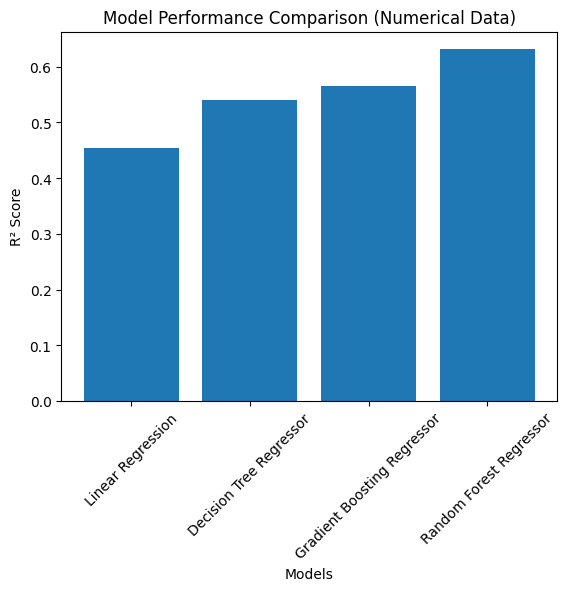

In [ ]:
plt.bar(models, values)
plt.xticks(rotation=45)
plt.xlabel('Models')
plt.ylabel('R² Score')
plt.title('Model Performance Comparison (Numerical Data)')
plt.show()

As we can see above, the Random Forest model is better than the others for different reasons:
- Random Forest trains a set of decision trees with different subsets -> avoid overfitting
- Random Forest captures non-linear problem (real life problem are never perfectly linear)
- Random Forest computes the variance by the average of all the small trees (Decision Tree might has a huge variance) -> more stable

### Business recommendations

Based on the overall results we have obtained, we can answer the questions we asked ourselves at the start of the report. 
> Is money strong enough to determine profitability, popularity and public appreciation of movies?  

No. Profitability, popularity and public appreciation of movies do not cause budget requirements, nor do they correlate the latter. 

We think that passion and luck determine these three elements significantly more. 

> Are movies so plain that one may guess their genres with only their overview? 

Yes, but no.  

Yes, because it seems like movie overviews offer enough information to guess the movie genres accurately.  
No, because most movies are not plain. 